# Basic Imports

In [1]:
import self_distillation
import saving_loading
import generate
import wandb
import util
import os

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb
os.environ['WANDB_NOTEBOOK_NAME'] = "Cin_256_custom.ipynb"

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

# config_path=f"{cwd}/models/configs/celebahq-ldm-vq-4.yaml"
# model_path=f"{cwd}/models/CelebA.ckpt"

teacher, sampler_teacher = util.create_models(config_path, model_path, student=False)
original, sampler_original = util.create_models(config_path, model_path, student=False)

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc


Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\Users\Administrator\anaconda3\envs\DSD\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [12]:
sampler_original.make_schedule(ddim_num_steps=36, ddim_eta=0.0, verbose=False)

IndexError: index 1000 is out of bounds for dimension 0 with size 1000

test


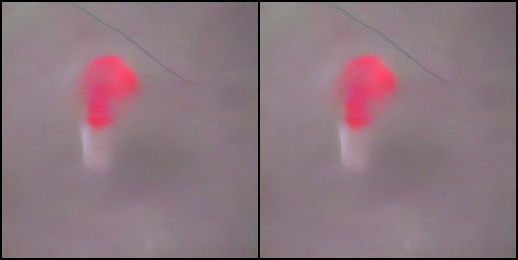

In [7]:
# images, _ = util.compare_teacher_student_x0(teacher, sampler_teacher, original, sampler_original, steps=[2, 4, 8, 16], prompt=[992])
images, _ = util.compare_teacher_student(teacher, sampler_teacher, original, sampler_original, steps=[2], prompt=[992])
images

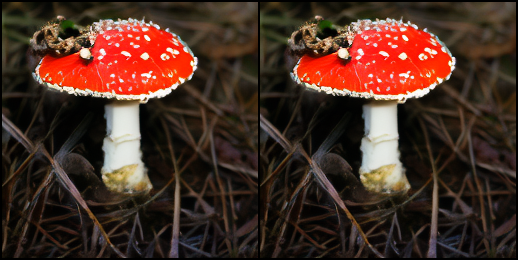

In [7]:
images, _ = util.compare_teacher_student(teacher, sampler_teacher, original, sampler_original, steps=[38], prompt=[992])
images

In [2]:
# from util import *
# import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb
os.environ['WANDB_NOTEBOOK_NAME'] = "Cin_256_custom.ipynb"

# config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
# model_path=f"{cwd}/models/cin256_original.ckpt"
teacher, sampler_teacher = util.create_models(config_path, model_path, student=False)
path = "C:\Diffusion_Thesis\cin_256\data\\trained_models\iterative\\2.pt"
student, sampler_student, optimizer, scheduler = util.load_trained(path, config_path)

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc


Loading model from c:\Diffusion_Thesis\cin_256/models/CelebA.ckpt


c:\Users\Administrator\anaconda3\envs\DSD\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Training LatentDiffusion as an unconditional model.
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Training LatentDiffusion as an unconditional model.


In [50]:
import os
import shutil

def organize_images(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    # Loop through each file
    for file in files:
        # Get the number before the first "_" in the filename
        number = file.split("_")[0]

        # Create a folder with that number if it doesn't exist
        if not os.path.exists(os.path.join(folder_path, number)):
            os.mkdir(os.path.join(folder_path, number))

        # Move the file to that folder
        shutil.move(os.path.join(folder_path, file), os.path.join(folder_path, number, file))

organize_images(f"{cwd}/saved_images/8")

In [29]:

import torch
import torchvision.models as models

model = models.inception_v3(pretrained=True)
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

def preprocess(img):
    transform = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img)
    # img_tensor = img_tensor.unsqueeze(0)
    return img_tensor


import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets



import numpy as np
from scipy.stats import entropy

def calculate_inception_score(model, fake_images, batch_size=32, splits=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    scores = []
    dataloader = data.DataLoader(fake_images, batch_size=batch_size)

    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        with torch.no_grad():
            pred = F.softmax(model(batch), dim=1).cpu().numpy()
            scores.append(pred)

    scores = np.concatenate(scores, axis=0)
    kl_divs = []
    chunk_size = len(scores) // splits

    for i in range(splits):
        chunk = scores[i*chunk_size:(i+1)*chunk_size, :]
        mean_probs = np.mean(chunk, axis=0)
        kl_div = entropy(mean_probs, qk=np.mean(chunk, axis=0), base=2)
        kl_divs.append(kl_div)

    return np.exp(np.mean(kl_divs))

inception_score = calculate_inception_score(model=model, fake_images=trained)
print("Inception score:", inception_score)

Inception score: 1.0


In [ ]:
trained

In [ ]:
path = f"{cwd}/saved_images/8"
inception_score(trained)

inception.compute()

In [ ]:
trained

In [2]:
import torch

from torchvision import transforms

from PIL import Image

In [8]:
trained_path = "C:\Diffusion_Thesis\cin_256\saved_images\\trained_unit_4\8"
original_path = "C:\Diffusion_Thesis\cin_256\saved_images\\original_unit_4\8"
# original_path = "C:\Diffusion_Thesis\cin_256\saved_images\original_scheduler\\64"


In [21]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        if img is not None:
            if img.mode == 'RGB':
                transform = transforms.Compose([transforms.ToTensor()])
                # tensor_img = transform(img)
                tensor_img = preprocess(img)
                # tensor_img = (tensor_img * 255).type(torch.uint8)
                images.append(tensor_img)
    tensor_images = torch.stack(images)
    return tensor_images


In [22]:
trained = load_images_from_folder(trained_path)
original = load_images_from_folder(original_path)

In [ ]:
len(trained)

In [ ]:
from torchmetrics.image.inception import InceptionScore
inception = InceptionScore(feature=2048)
inception.update(original)
inception.compute()

In [42]:
from torchmetrics.image.inception import InceptionScore
inception = InceptionScore(feature=2048)
inception.update(trained)
inception.compute()

(tensor(1.0756), tensor(0.0479))

# Teacher-Student Distillation

In [ ]:
ddim_steps = [64]
run_name = "unconditional"
generations = 100000
lr=0.00000001
config = f"{cwd}/models/configs/cin256-v2-custom.yaml"
original_model_path = f"{cwd}/models/cin256_original.ckpt"
distill(ddim_steps, generations, run_name, config, original_model_path, lr=lr, start_trained=False)

## Create teacher and student model

Only the student or teacher:

(setting student=False will only return a single model)

In [2]:
teacher, sampler_teacher = util.create_models(config_path, model_path, student=False)
# student, sampler_student = create_models(config_path, model_path, student=False)

Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


# Teacher-Student Distillation

# Comparing trained student with Teacher


In [1]:
# from util import *
# import wandb
import self_distillation
import saving_loading
import generate
import wandb
import util
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb
os.environ['WANDB_NOTEBOOK_NAME'] = "Cin_256_custom.ipynb"
config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

# config_path=f"{cwd}/models/configs/celebahq-ldm-vq-4.yaml"
# model_path=f"{cwd}/models/CelebA.ckpt"

model_path=f"{cwd}/models/cin256_original.ckpt"
teacher, sampler_teacher = util.create_models(config_path, model_path, student=False)
# path = "C:\Diffusion_Thesis\cin_256\data\\trained_models\\naive\cin_50k_1e-8\\32.pt"
path = "C:\Diffusion_Thesis\cin_256\data\\trained_models\gradual_linear\DSDGL_cin_50k_4e-9\\1.pt"
path = "C:\Diffusion_Thesis\cin_256\data\\trained_models\\naive\cin_50k_1e-8_noschedule\\32.pt"
path = "C:\Diffusion_Thesis\cin_256\data\\trained_models\gradual_exp\DSDGEXP_cin_50k_4e-9\\1.pt"
student, sampler_student, optimizer, scheduler = util.load_trained(path, config_path)


wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc


Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\Users\Administrator\anaconda3\envs\DSD\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


WITHOUT schedule

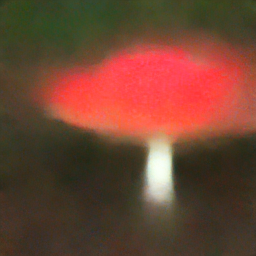

In [2]:
img, x_T_copy, class_prompt, intermediates  = generate.generate_images(student, sampler_student, steps=16, scale=3, keep_intermediates=False,
                                            x_0=True, class_prompt=992)
img

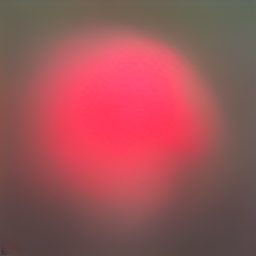

In [3]:
img, x_T_copy, class_prompt, intermediates  = generate.generate_images(teacher, sampler_teacher, steps=16, scale=3, keep_intermediates=False,
                                            x_0=True, class_prompt=992)
img

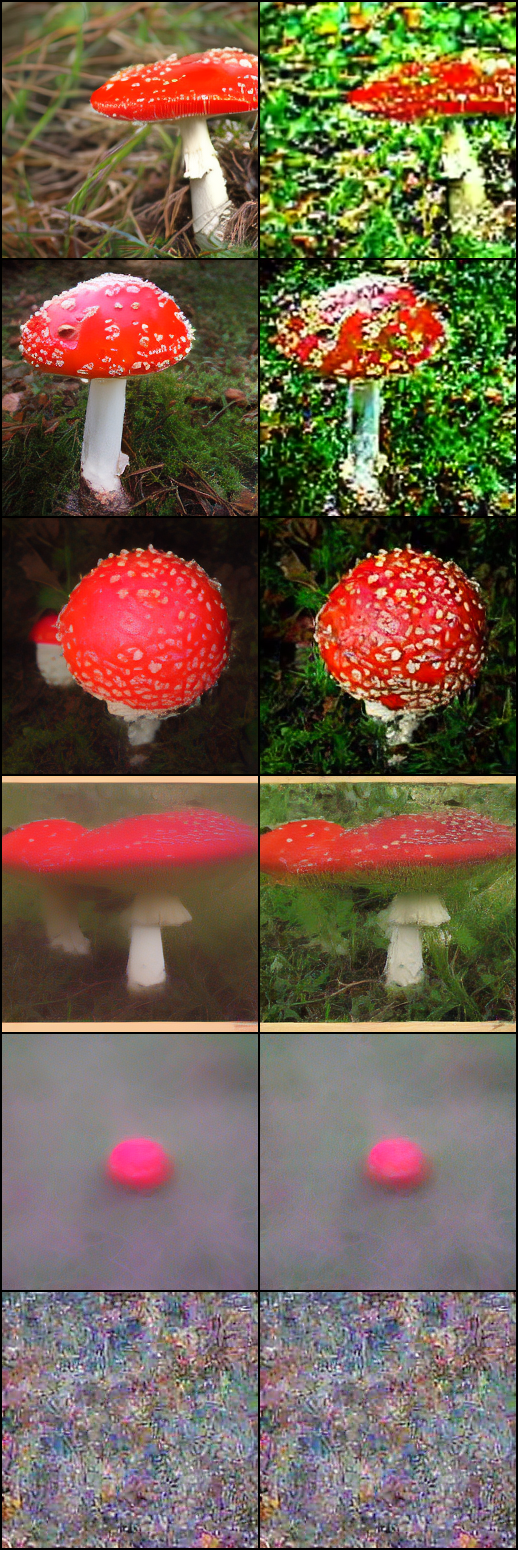

In [4]:

images, _ = util.compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[32, 16,8, 4, 2, 1], prompt=992)
# images, _ = util.compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4], prompt=992)
images

In [6]:
util.get_fid(student, sampler_student, num_imgs=1000, name="DSDGEXP_cin_50k_4e-9", instance=4, steps=[4])

100%|██████████| 32/32 [00:06<00:00,  4.93it/s]


[68.83332016139587]

In [7]:
util.get_fid(teacher, sampler_teacher, num_imgs=1000, name="original_test", instance=4, steps=[4])

100%|██████████| 32/32 [00:06<00:00,  5.00it/s]


[69.62534277601958]

In [8]:
util.get_fid(student, sampler_student, num_imgs=500, name="cin_50k_noschedule_x0", instance=4, steps=[4], x_0=True)

100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


[276.57968163823114]

In [9]:
util.get_fid(teacher, sampler_teacher, num_imgs=500, name="original_test_x0", instance=4, steps=[4],x_0=True)

100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


[351.54266565679205]

# Self-Distillation

In [1]:
import self_distillation
import saving_loading
import generate
import wandb
import util
import os

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb
os.environ['WANDB_NOTEBOOK_NAME'] = "Cin_256_custom.ipynb"

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

# config_path=f"{cwd}/models/configs/celebahq-ldm-vq-4.yaml"
# model_path=f"{cwd}/models/CelebA.ckpt"

teacher, sampler_teacher = util.create_models(config_path, model_path, student=False)
original, sampler_original = util.create_models(config_path, model_path, student=False)

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc


Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\Users\Administrator\anaconda3\envs\DSD\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [2]:
step_scheduler = "iterative"
model_NAME = "CIN256_weirdLR"

In [5]:
steps = 64
generations = 1000
lr = 0.000000002
decrease_steps = True




run_name = f"HOME_{model_NAME}-DSD-{step_scheduler}-{steps}-{lr}-{generations}"




notes = f"""Self-distilling the {steps} step original teacher into a smaller continuous model,"""
wandb_session = util.wandb_log(name=run_name, lr=lr, model=teacher, tags=["DSD Iterative", run_name, model_NAME], notes=notes)
wandb.run.log_code(".")
session = wandb_session
# session=None
optimizer, scheduler = util.get_optimizer(sampler_teacher, iterations=generations, lr=lr)

self_distillation.self_distillation_CIN(teacher, sampler_teacher, optimizer=optimizer, scheduler=scheduler, session=session, 
                      steps=steps, generations=generations, early_stop=False, 
                      run_name=run_name, decrease_steps=decrease_steps, step_scheduler=step_scheduler)


TypeError: self_distillation_CIN() missing 2 required positional arguments: 'original' and 'sampler_original'

In [4]:
original, sampler_original = util.create_models(config_path, model_path, student=False)

Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


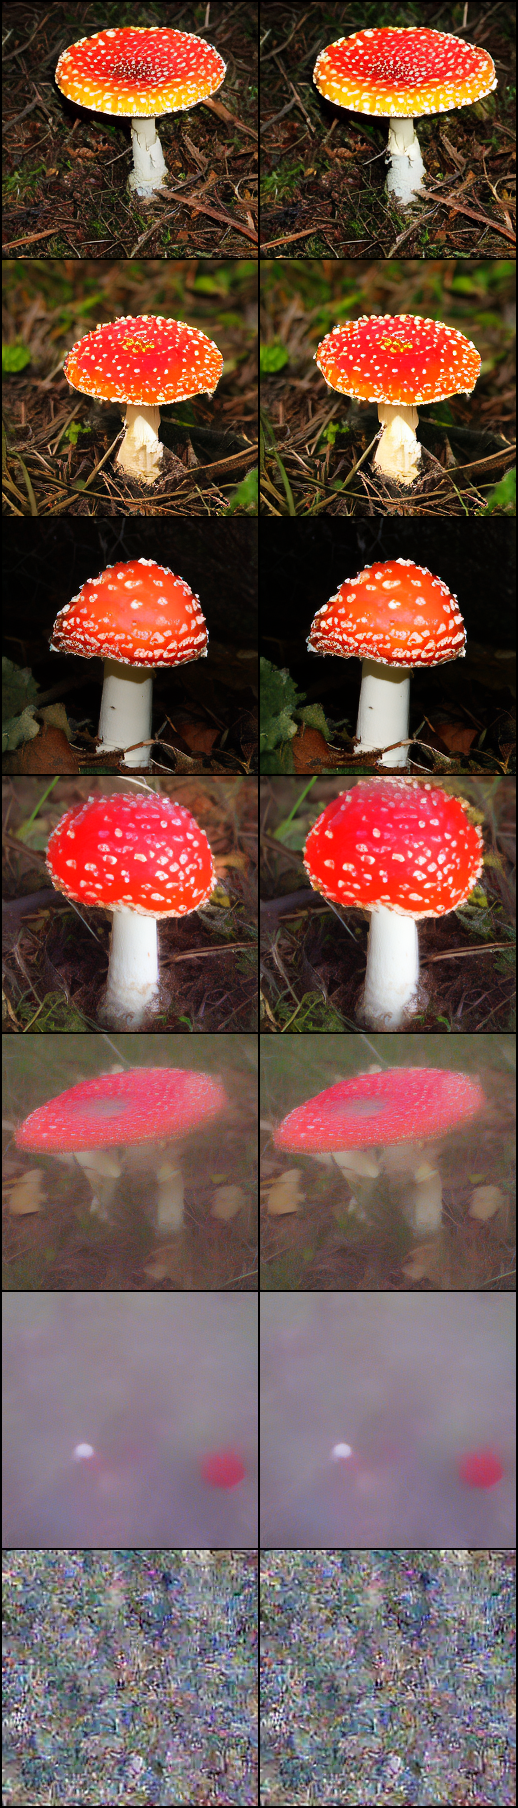

In [5]:
images, _ = util.compare_teacher_student(original, sampler_original, teacher, sampler_teacher, steps=[64, 32, 16, 8,  4, 2, 1], prompt=992)
# images, _ = util.compare_teacher_student_celeb(original, sampler_original, teacher, sampler_teacher, steps=[64, 32, 16, 8,  4, 2, 1])
images

In [31]:

import torch

sampler_teacher.make_schedule(ddim_num_steps=64, ddim_eta=0.0, verbose=False)
xc = torch.tensor([992])
c_teacher = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
sc = teacher.get_learned_conditioning(
                            {teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)}
                            )
temp = []
samples_ddim = None
for step in range(64):
    samples_ddim, teacher_intermediate, x_T, pred_x0_teacher, a_t_teacher = sampler_teacher.sample(S=1,
                                                                        conditioning=c_teacher,
                                                                        batch_size=1,
                                                                        shape=[3, 64, 64],
                                                                        verbose=False,
                                                                        x_T=samples_ddim,
                                                                        
                                                                        unconditional_guidance_scale=3.0,
                                                                        unconditional_conditioning=sc, 
                                                                        eta=0.0,
                                                                        keep_intermediates=False,
                                                                        intermediate_step =step,
                                                                        steps_per_sampling = 1,
                                                                        total_steps = 64)
    
    x_T_teacher_decode = sampler_teacher.model.decode_first_stage(pred_x0_teacher)
    teacher_target = torch.clamp((x_T_teacher_decode+1.0)/2.0, min=0.0, max=1.0)
    temp.append(teacher_target)

In [ ]:
img, grid = util.compare_latents(temp)
img

In [4]:
util.save_model(sampler_teacher, optimizer, scheduler, name=step_scheduler, steps=1, run_name=run_name)

# FID Calculations

In [4]:
util.save_images(teacher, sampler_teacher, 50000, "original", [64, 32, 16, 8, 4, 2, 1])
# util.save_images(teacher, sampler_teacher, 100, "original_unit_4", [8])

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


In [5]:
util.save_images(student, sampler_student, 100, "trained_unit_4", [8])

100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


In [ ]:
util.get_fid(teacher, sampler_teacher, num_imgs=1000, name="original_unit_4", instance = 4, steps=[8])

In [ ]:
util.get_fid(student, sampler_student, num_imgs=500, name="trained_unit_4", instance = 4, steps=[8])

## Comparing FID

In [3]:
from pytorch_fid import fid_score
fid_score.calculate_fid_given_paths(["C:/val_saved/real_fid_both.npz", "C:\Diffusion_Thesis\cin_256\saved_images\original_unit_4\\8"],batch_size=64,device="cuda", dims=2048 )

100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


39.661797993970026

In [4]:
from pytorch_fid import fid_score
fid_score.calculate_fid_given_paths(["C:/val_saved/real_fid_both.npz", "C:\Diffusion_Thesis\cin_256\saved_images\\trained_unit_4\\8"],batch_size=64,device="cuda", dims=2048 )

100%|██████████| 24/24 [00:11<00:00,  2.18it/s]


41.62617599041789

# Helpful Functions

## Generating WITHOUT intermediates saved

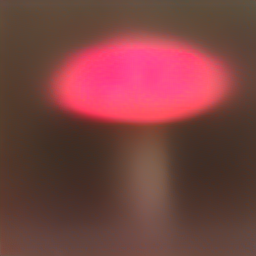

In [40]:
img, x_T_copy, class_prompt, intermediates  = generate.generate_images(teacher, sampler_teacher, steps=16, scale=3, keep_intermediates=False,
                                            x_0=True, class_prompt=992)
img

## Generating WITH intermediates saved

In [ ]:
intermediates, starting_noise, class_prompt = return_intermediates_for_student(teacher, sampler_teacher, steps=250)

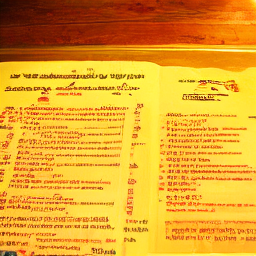

In [ ]:
latent_to_img(teacher, intermediates[125])

## Creating a dataset

In [ ]:
dataset_path = f"{cwd}/data/pre_generated/teacher_128/"
dataset_name = "teacher_128.pt"
make_dataset(teacher, sampler_teacher, 501, 128, dataset_path, dataset_name)

100%|██████████| 500/500 [1:26:03<00:00, 10.33s/it]


## Train student from pre-generated teacher dataset

In [ ]:
data_dir = f"{cwd}/data/pre_generated/teacher_128/"
datasets = os.listdir(data_dir)

In [ ]:
notes = """This is a serious attempt to distill the 128 step original teacher into a 64 step student, trained on 32000 instances"""
wandb_session = wandb_log(name="Train_student_on_128_pretrained", lr=0.00000001, model=student, tags=["distillation"], notes=notes)

optimizer, scheduler = get_optimizer(sampler_student, iterations=64*500)

dataset = torch.load(data_dir + datasets[0])
train_student_from_dataset(student, sampler_student, dataset, 64, optimizer, scheduler, early_stop=True, session=wandb_session)

wandb.finish()

save_model(sampler_student, optimizer, scheduler, name="lr8_scheduled", steps=64)

## Save and Loading trained models

In [ ]:
save_model(sampler_student, optimizer, scheduler, name="lr8_scheduled", steps=64)

In [ ]:
path = f"{cwd}/data/trained_models/64/student_lr8_scheduled.pt"
student, sampler_student, optimizer, scheduler = util.load_trained(path, config_path)

## Direct Comparison

In [ ]:
images, _ = util.compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4, 8, 16, 32, 64, 128])
images



In [17]:
import math
gradient_updates = 1000
halving_steps = []
for i in range(math.floor(math.log(32)/math.log(2))+1):
    halving_steps.append(int(gradient_updates * (1 / (math.floor(math.log(32)/math.log(2))+1)) * i))

In [20]:
halvings = math.floor(math.log(32)/math.log(2)) + 1
halvings

6

In [1]:
import self_distillation
import saving_loading
import generate
import wandb
import util
import os

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb
os.environ['WANDB_NOTEBOOK_NAME'] = "Cin_256_custom.ipynb"

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

# config_path=f"{cwd}/models/configs/celebahq-ldm-vq-4.yaml"
# model_path=f"{cwd}/models/CelebA.ckpt"

original, sampler_original = util.create_models(config_path, model_path, student=False)
student, sampler_student = util.create_models(config_path, model_path, student=False)

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc


Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\Users\Administrator\anaconda3\envs\DSD\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [2]:
decrease_steps = True
optimizer, scheduler = util.get_optimizer(sampler_student, iterations=400, lr=0.0000001)

In [28]:
gradient_updates = generations
ddim_steps_student = steps
TEACHER_STEPS = 2
ddim_eta = 0.0
scale = 3.0
optimizer=optimizer
averaged_losses = []
criterion = nn.MSELoss()
instance = 0
generation = 0
all_losses = []

if step_scheduler == "iterative":
    halvings = math.floor(math.log(32)/math.log(2)) + 1
    updates_per_halving = int(gradient_updates / halvings)
intermediate_generation_compare = int(gradient_updates * 0.8 / 10)
if step_scheduler == "FID":
    if os.path.exists(f"{cwd}/saved_images/FID/{run_name}"):
        print("FID folder exists")
        shutil.rmtree(f"{cwd}/saved_images/FID/{run_name}")

with torch.no_grad():
    with student.ema_scope():              
            
            sampler_student.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
            sampler_original.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
            
            
            if step_scheduler =="FID":
                current_fid = util.get_fid(student, sampler_student, num_imgs=100, name=run_name, instance = 0, steps=[ddim_steps_student])
            
            updates = ddim_steps_student

            for i in range(halvings):
                if instance != 0:
                    util.save_model(sampler_student, optimizer, scheduler, name=step_scheduler, steps=updates, run_name=run_name)
                updates = int(updates / TEACHER_STEPS)
                generations = updates_per_halving // updates
                print("Distilling to:", updates)
                
                
                with tqdm.tqdm(range(generations)) as tepoch:

                    for i in tepoch:
                        generation += 1
                        losses = []        
            
                        samples_ddim= None
                        predictions_temp = []
                        for steps in range(updates):  

                                with autocast():

                                    with torch.enable_grad():
                                        
                                        instance += 1
                                    
                                        
                                        
                                        optimizer.zero_grad()
                                        
                                        
                                        samples_ddim, pred_x0_student, _, at= sampler_student.sample_student(S=1,
                                                                            conditioning=None,
                                                                            batch_size=1,
                                                                            shape=[3, 64, 64],
                                                                            verbose=False,
                                                                            x_T=samples_ddim,
                                                                    
                                                                            unconditional_guidance_scale=scale,
                                                                            unconditional_conditioning=None, 
                                                                            eta=ddim_eta,
                                                                            keep_intermediates=False,
                                                                            intermediate_step = steps*2,
                                                                            steps_per_sampling = 1,
                                                                            total_steps = updates*2)
                                    

                                    with torch.no_grad():
                                        
                                        samples_ddim, _, _, pred_x0_teacher, _ = sampler_student.sample(S=1,
                                                                        conditioning=None,
                                                                        batch_size=1,
                                                                        shape=[3, 64, 64],
                                                                        verbose=False,
                                                                        x_T=samples_ddim,
                                                                        unconditional_guidance_scale=scale,
                                                                        unconditional_conditioning=None, 
                                                                        eta=ddim_eta,
                                                                        keep_intermediates=False,
                                                                        intermediate_step = steps*2+1,
                                                                        steps_per_sampling = 1,
                                                                        total_steps = updates*2)     
                                    
                                    
                                
                                    with torch.enable_grad():    
                                        if type == "home":
                                            # AUTOCAST:
                                            signal = at
                                            noise = 1 - at
                                            log_snr = torch.log(signal / noise)
                                            weight = max(log_snr, 1)
                                            loss = weight * criterion(pred_x0_student, pred_x0_teacher.detach())
                                            scaler.scale(loss).backward()
                                            scaler.step(optimizer)
                                            scaler.update()
                                            # torch.nn.utils.clip_grad_norm_(sampler_student.model.parameters(), 1)
                                            
                                            scheduler.step()
                                            losses.append(loss.item())

                                        else:
                                            # NO AUTOCAST:
                                            signal = at
                                            noise = 1 - at
                                            log_snr = torch.log(signal / noise)
                                            weight = max(log_snr, 1)
                                            loss = weight * criterion(pred_x0_student, pred_x0_teacher.detach())
                                            loss.backward()
                                            optimizer.step()
                                            scheduler.step()
                                            # torch.nn.utils.clip_grad_norm_(sampler_student.model.parameters(), 1)
                                            
                                            losses.append(loss.item())
                                        
                                    if session != None and generation % 100 == 0 and generation > 0:
                                            
                                        x_T_teacher_decode = sampler_student.model.decode_first_stage(pred_x0_teacher)
                                        teacher_target = torch.clamp((x_T_teacher_decode+1.0)/2.0, min=0.0, max=1.0)
                                        x_T_student_decode = sampler_student.model.decode_first_stage(pred_x0_student.detach())
                                        student_target  = torch.clamp((x_T_student_decode +1.0)/2.0, min=0.0, max=1.0)
                                        predictions_temp.append(teacher_target)
                                        predictions_temp.append(student_target)
                                        
                                

                                    # if session != None and instance % 10000 == 0 and generation > 0:
                                    #     fids = util.get_fid_celeb(student, sampler_student, num_imgs=100, name=run_name, instance = instance+1, steps=[64, 32, 16, 8, 4, 2, 1])
                                    #     session.log({"fid_64":fids[0]})
                                    #     session.log({"fid_32":fids[1]})
                                    #     session.log({"fid_16":fids[2]})
                                    #     session.log({"fid_8":fids[3]})
                                    #     session.log({"fid_4":fids[4]})
                                    #     session.log({"fid_2":fids[5]})
                                    #     session.log({"fid_1":fids[6]})
                                    
                                    if session != None and instance % 2000 == 0:
                                
                                        # with torch.no_grad():
                                        #     images, _ = util.compare_teacher_student_celeb(original, sampler_original, student, sampler_student, steps=[64, 32, 16, 8,  4, 2, 1])
                                        #     images = wandb.Image(_, caption="left: Teacher, right: Student")
                                        #     wandb.log({"pred_x0": images})
                                        #     # images, _ = util.compare_teacher_student_with_schedule(original, sampler_original, student, sampler_student, steps=[64, 32, 16, 8,  4, 2, 1], prompt=992)
                                        #     # images = wandb.Image(_, caption="left: Teacher, right: Student")
                                        #     # wandb.log({"schedule": images})
                                        #     sampler_student.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
                                        #     sampler_original.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)

                        # if generation > 0 and generation % 20 == 0 and ddim_steps_student != 1 and step_scheduler=="FID":
                        #     fid = util.get_fid(student, sampler_student, num_imgs=100, name=run_name, 
                        #                 instance = instance, steps=[ddim_steps_student])
                        #     if fid[0] <= current_fid[0] * 0.9 and decrease_steps==True:
                        #         print(fid[0], current_fid[0])
                        #         if ddim_steps_student in [16, 8, 4, 2, 1]:
                        #             name = "intermediate"
                        #             saving_loading.save_model(sampler_student, optimizer, scheduler, name, steps * 2, run_name)
                        #         if ddim_steps_student != 2:
                        #             ddim_steps_student -= 2
                        #             updates -= 1
                        #         else:
                        #             ddim_steps_student = 1
                        #             updates = 1    
                        #         current_fid = fid
                        #         print("steps decresed:", ddim_steps_student)    

                        if session != None:
                            with torch.no_grad():
                                if session != None and generation % 100 == 0 and generation > 0:
                                    img, grid = util.compare_latents(predictions_temp)
                                    images = wandb.Image(grid, caption="left: Teacher, right: Student")
                                    wandb.log({"Inter_Comp": images})
                                    del img, grid, predictions_temp, x_T_student_decode, x_T_teacher_decode, student_target, teacher_target
                                    torch.cuda.empty_cache()
                        
                        all_losses.extend(losses)
                        averaged_losses.append(sum(losses) / len(losses))
                        if session != None:
                            session.log({"generation_loss":averaged_losses[-1]})
                        tepoch.set_postfix(epoch_loss=averaged_losses[-1])

Distilling to: 8


100%|██████████| 4/4 [00:17<00:00,  4.27s/it, epoch_loss=0.00876]


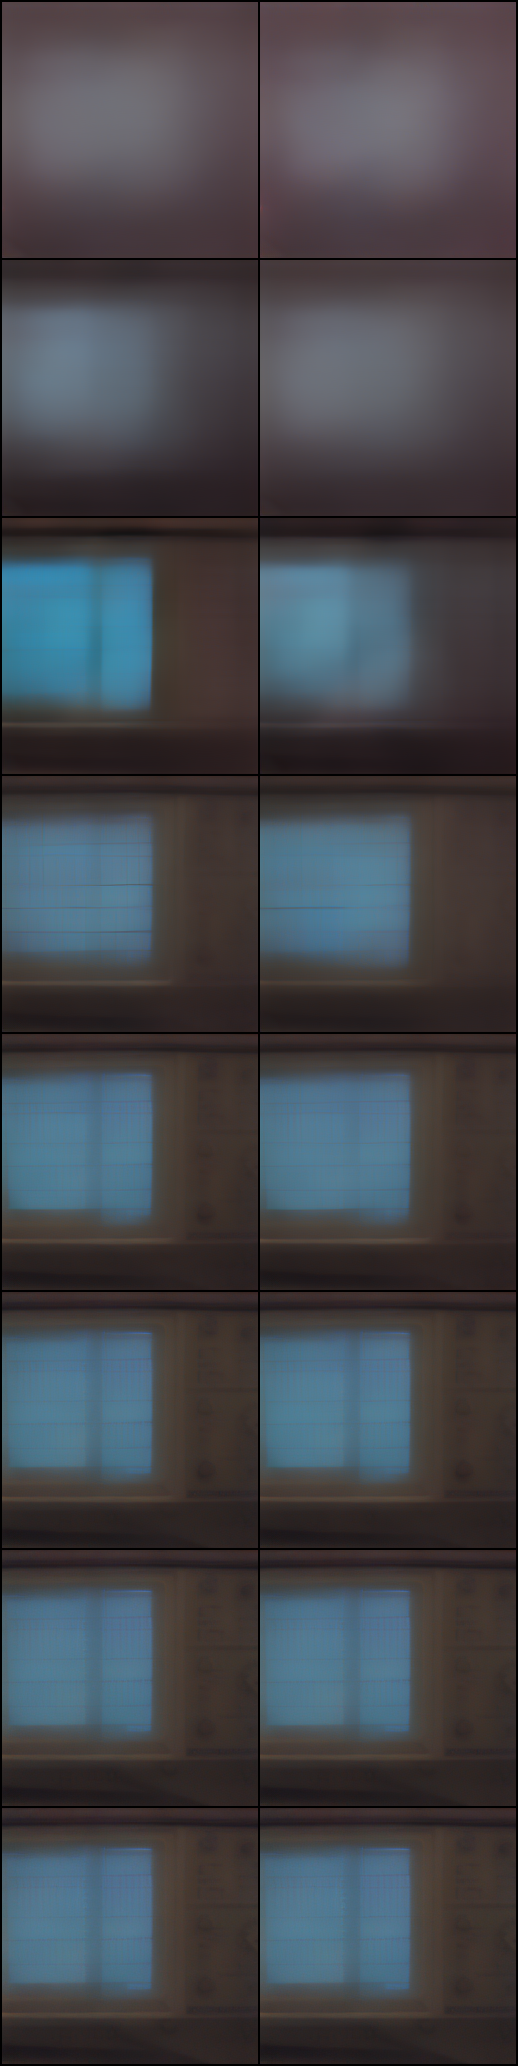

In [29]:
img

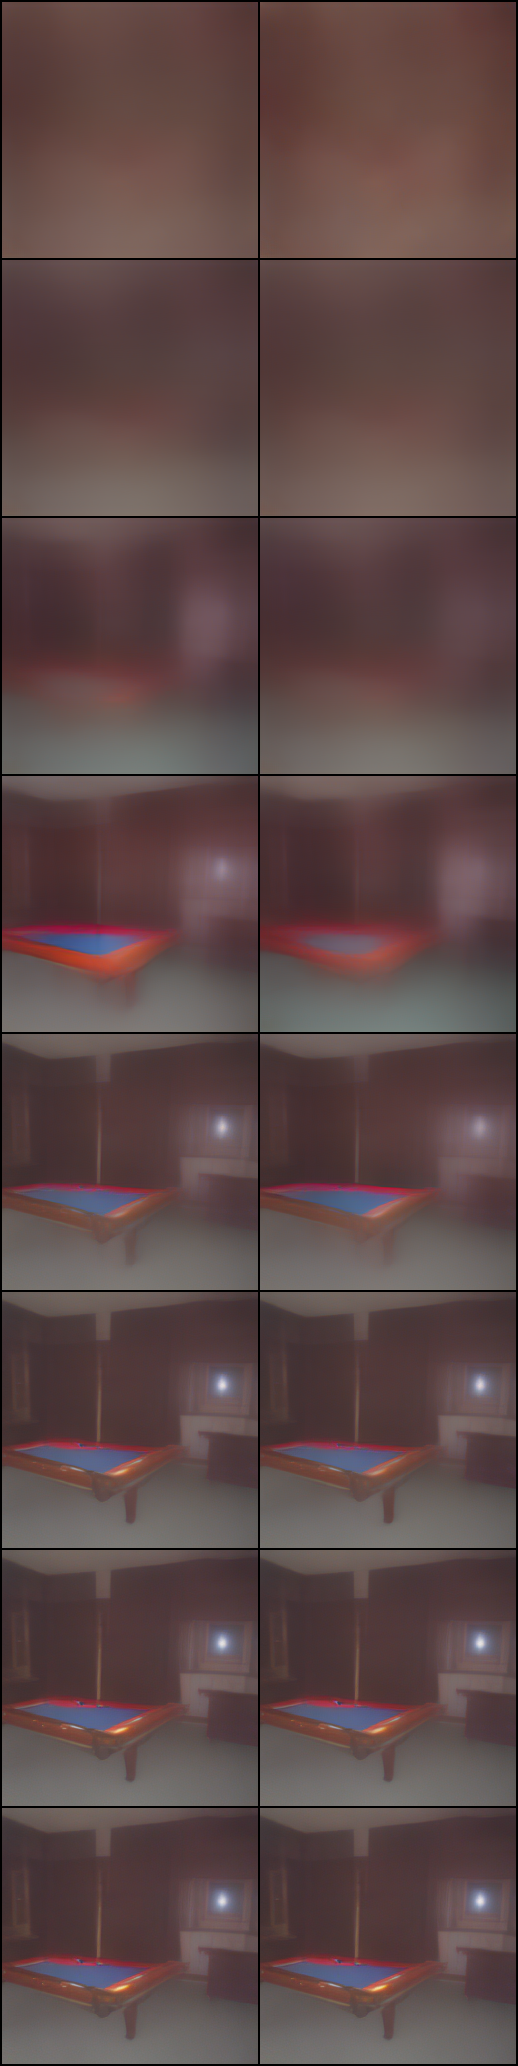

In [21]:
img